# New York City - Taxi and Limousine Commission
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [1]:
# %load nbheader.py
%reload_ext autoreload
%autoreload 2
from typing import List, Tuple, Dict, Any, Union
import sys
import os
import re
import json
import datetime
import numpy as np
import pandas as pd
settings = {
    'max_columns': 50,
    'max_colwidth': 100,
    # 'min_rows':40,
    'max_rows': 200,
    # 'precision': 3,
    'float_format': lambda x: f'{x:,.2f}',
    }
for option, value in settings.items():
    pd.set_option("display.{}".format(option), value)
import matplotlib.pyplot as plt



# Load Data
Just one data file to explore

In [2]:
ls -lRh /data/nyc_tlc_trip_records/2023/

/data/nyc_tlc_trip_records/2023/:
total 3.7G
-rw-rw-r--. 1 pmolnar pmolnar  11M Mar 20  2023 fhv_tripdata_2023-01.parquet
-rw-rw-r--. 1 pmolnar pmolnar  13M May  1 11:32 fhv_tripdata_2023-02.parquet
-rw-rw-r--. 1 pmolnar pmolnar  15M May 19 10:14 fhv_tripdata_2023-03.parquet
-rw-rw-r--. 1 pmolnar pmolnar  14M Jun 23 10:05 fhv_tripdata_2023-04.parquet
-rw-rw-r--. 1 pmolnar pmolnar  15M Jul 26 10:48 fhv_tripdata_2023-05.parquet
-rw-rw-r--. 1 pmolnar pmolnar  14M Aug 22 09:23 fhv_tripdata_2023-06.parquet
-rw-rw-r--. 1 pmolnar pmolnar  11M Sep 21 18:40 fhv_tripdata_2023-07.parquet
-rw-rw-r--. 1 pmolnar pmolnar 452M Mar 20  2023 fhvhv_tripdata_2023-01.parquet
-rw-rw-r--. 1 pmolnar pmolnar 438M May  1 11:32 fhvhv_tripdata_2023-02.parquet
-rw-rw-r--. 1 pmolnar pmolnar 499M May 19 12:09 fhvhv_tripdata_2023-03.parquet
-rw-rw-r--. 1 pmolnar pmolnar 470M Jun 23 10:05 fhvhv_tripdata_2023-04.parquet
-rw-rw-r--. 1 pmolnar pmolnar 490M Jul 26 10:48 fhvhv_tripdata_2023-05.parquet
-rw-rw-r--. 1 pmolnar

In [2]:
df = pd.read_parquet('/data/nyc_tlc_trip_records/2023/')
print(f"Number of records: {df.shape[0]:,}")

Number of records: 3,066,766


In [8]:
display(df.dtypes)

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [ ]:
ls -lR /data/nyc_tlc_trip_records/

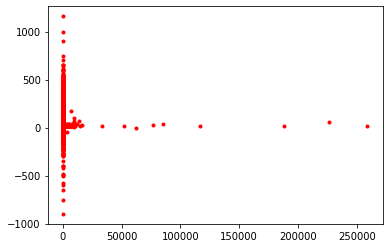

In [ ]:
df.shape

In [ ]:
df.describe(include='all', datetime_is_numeric=True).T

In [ ]:
df.dtypes

In [ ]:
df.describe().T

In [ ]:
df.describe(include=["object"]).T

In [ ]:
df.describe(include=["datetime64"], datetime_is_numeric=True, percentiles=[]).T

## Missing Values

In [ ]:
n_rows = df.shape[0]
for col in df.columns:
    n_null_values = pd.isnull(df[col]).sum()
    n_unique = df[pd.notnull(df[col])][col].drop_duplicates().shape[0]
    print(f"{col}: rows={n_rows:,}   nulls={n_null_values:,}   uniques={n_unique}:")
    

In [ ]:
def nulls_uniques_count(df: pd.DataFrame, include_cols: List[str] = [], exclude_cols: List[str] = []) -> pd.DataFrame:
    cols = df.columns if len(include_cols)==0 else list(set(df.columns).intersection(set(include_cols)))
    if len(exclude_cols)>0:
        cols = set(cols)-set(exclude_cols)
        
    nulls_uniques_count_dat = [{
        'col': col,
        'null_values': pd.isnull(df[col]).sum(),
        'unique': df[pd.notnull(df[col])][col].drop_duplicates().shape[0]
    } 
    for col in cols ]
    nulls_uniques_count_df = pd.DataFrame(nulls_uniques_count_dat)
    nulls_uniques_count_df.set_index('col', inplace=True)
    nulls_uniques_count_df['null_values_perc'] = nulls_uniques_count_df['null_values']/df.shape[0]
    nulls_uniques_count_df['unique_perc'] = nulls_uniques_count_df['unique']/df.shape[0]
    return nulls_uniques_count_df

In [ ]:
nulls_uniques_count(df)

In [ ]:
nulls_uniques_count_dat = [{
        'col': col,
        'null_values': pd.isnull(df[col]).sum(),
        'unique': df[pd.notnull(df[col])][col].drop_duplicates().shape[0]
    } 
    for col in df.columns
]
nulls_uniques_count_df = pd.DataFrame(nulls_uniques_count_dat)
nulls_uniques_count_df.set_index('col', inplace=True)
nulls_uniques_count_df['null_values_perc'] = nulls_uniques_count_df['null_values']/df.shape[0]
nulls_uniques_count_df['unique_perc'] = nulls_uniques_count_df['unique']/df.shape[0]
display(nulls_uniques_count_df)
# display(nulls_uniques_count_df)

In [ ]:
df.describe().T.join(nulls_uniques_count_df)

In [ ]:
pd.DataFrame(df.dtypes, columns=['field_name']).join(df.describe().T, how='inner')

In [ ]:
df.groupby('passenger_count').agg({'passenger_count': 'count'})

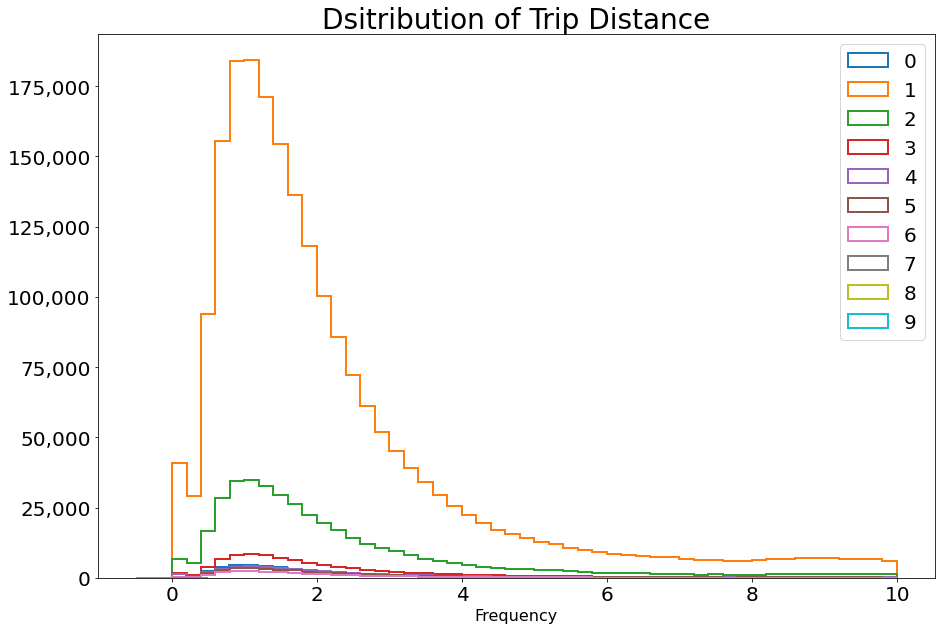

In [4]:
import matplotlib
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(15,10))
pass_count_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# mcolors.TABLEAU_COLORS
for n, c in zip(pass_count_values, list(mcolors.TABLEAU_COLORS)[:len(pass_count_values)]):
    plt.hist(df[(df.passenger_count==n)&(df.trip_distance<10)].trip_distance, bins=50, label=f'{n}', histtype='step', color=c, linewidth=2,)
plt.legend(fontsize="20")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.axes[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Trip Distance [miles]", fontsize=16)
plt.xlabel("Frequency", fontsize=16)
plt.title("Dsitribution of Trip Distance", fontsize=28)
fig.show()
fig.savefig('plot_1_15x10.png')

In [ ]:
plt.yticks()

In [ ]:
df[df.trip_distance<10]

In [ ]:
len(mcolors.TABLEAU_COLORS)

list(mcolors.TABLEAU_COLORS)

In [20]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [30]:
# List of numeric columns
num_cols = [ col for col, datyp in df.dtypes.items() if datyp in ['int64', 'float64'] ]

['VendorID',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

TypeError: 'function' object is not subscriptable

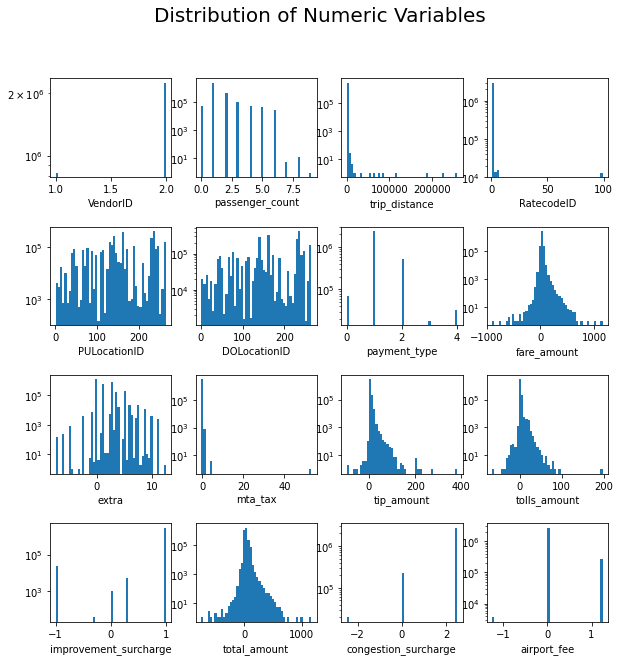

In [42]:
import math
a = math.ceil(math.sqrt(len(num_cols)))
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.5)
j = 0
for col in num_cols:
    j += 1
    plt.subplot(a, a, j)
    plt.hist(df[col], bins=50, log=True)
    plt.xlabel(col)
plt.suptitle("Distribution of Numeric Variables", fontsize=20)
plt.show()

In [47]:
scatt_cols = [ col for col in num_cols if 'ID' not in col] 

In [51]:
df2 = df.sample(1000)
scatt_cols = [ col for col in num_cols if 'ID' not in col] 

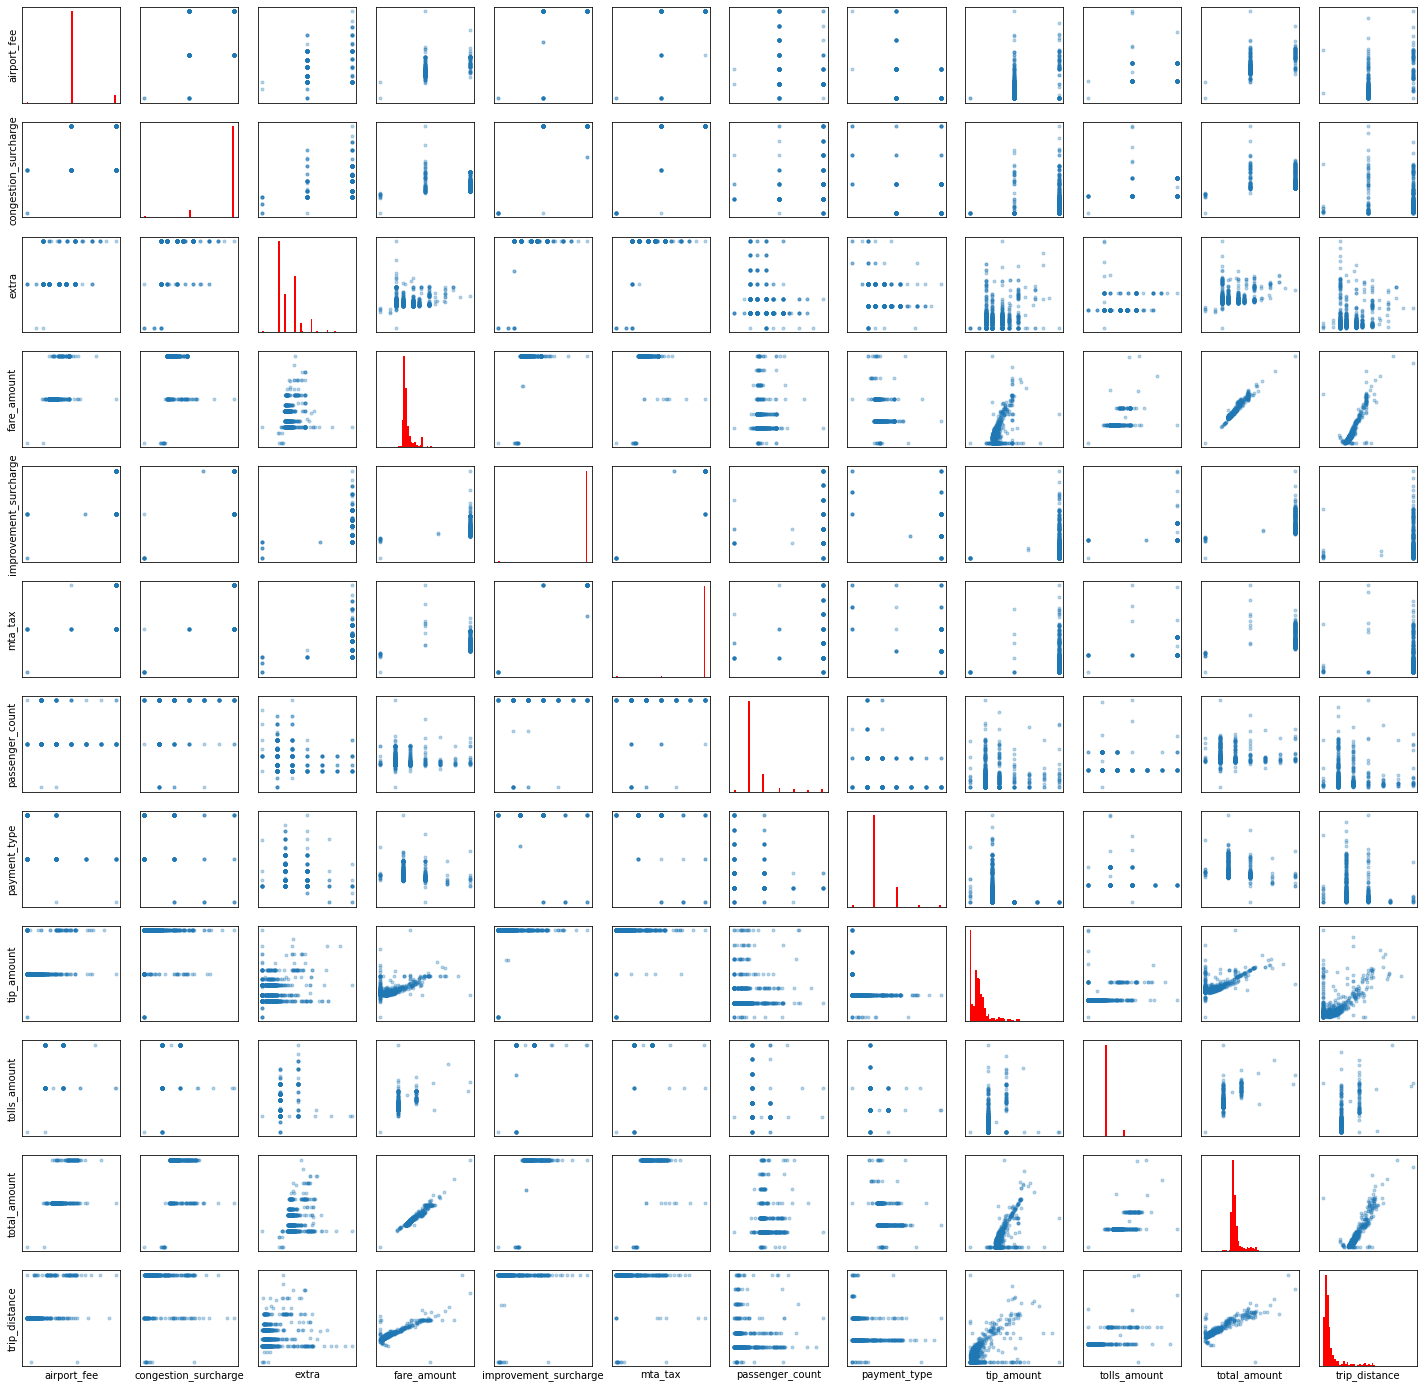

In [62]:
j = 0
n_scatt = len(scatt_cols)
fig = plt.figure(figsize=(25,25))
for row in sorted(scatt_cols):
    for col in sorted(scatt_cols):
        j += 1
        plt.subplot(n_scatt, n_scatt, j)
        if row == col:
            plt.hist(df2[col], bins=50, color='r')
        else:
            plt.plot(df2[row], df2[col], '.', alpha=0.3)
        plt.xticks([])
        plt.yticks([])
        if j % n_scatt == 1:
            plt.ylabel(row)
        if j / n_scatt > n_scatt - 1:
             plt.xlabel(col)
plt.show()

In [63]:
df.trip_distance.corr(df.total_amount)

0.016274433170143023

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa650d3abb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa650d3a340>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa6509462e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa650d22040>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa650d225e0>],
 'means': []}

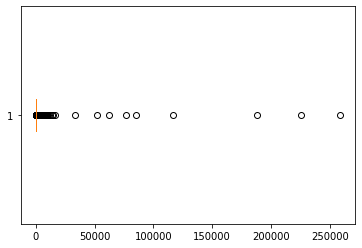

In [70]:
plt.boxplot(df.trip_distance, vert=False)

# PowerPoint

The default dimensions of a Powepoint slide are 13.33 inches by 7.5 inches.

E.g, a single figure on the slide can have the dimensions of 11x6.5

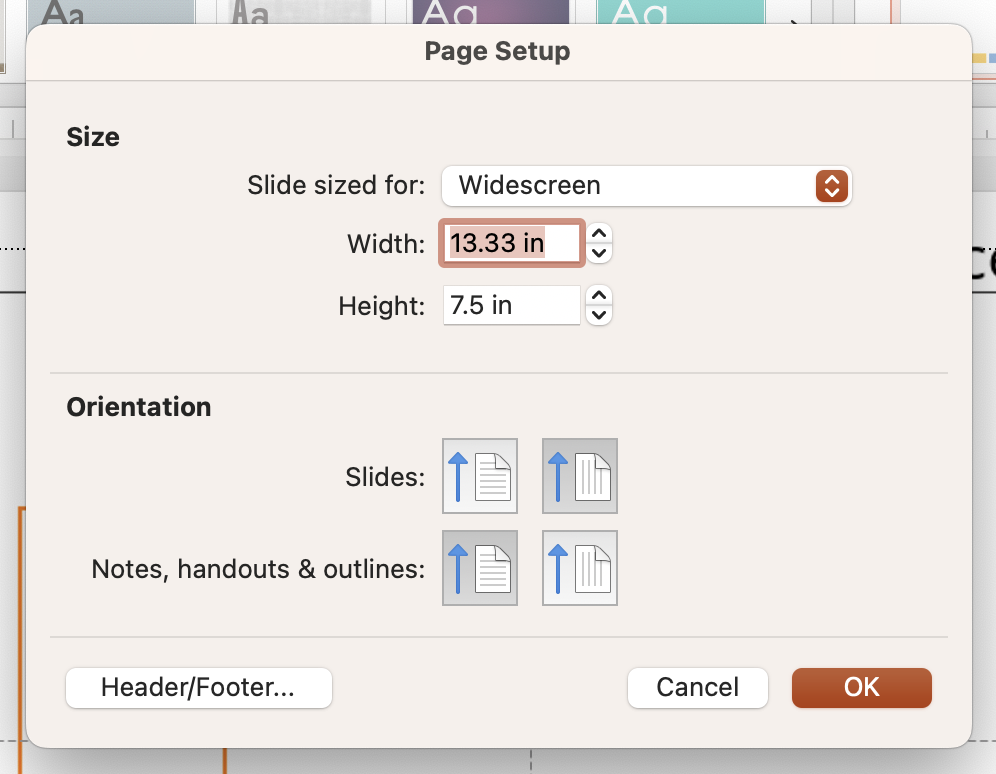

## Distribution of Trip Distance

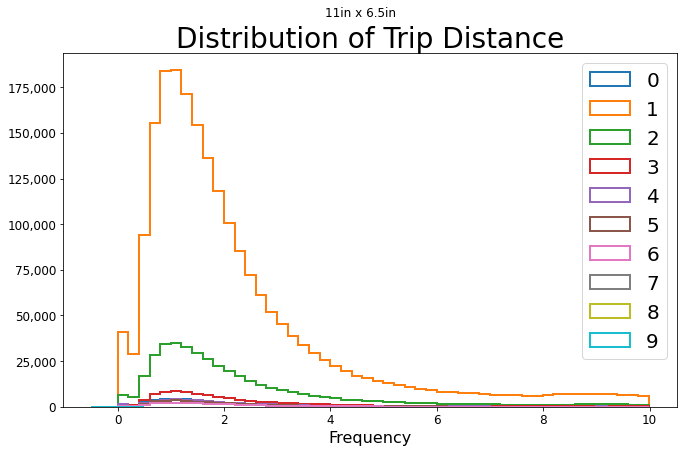

In [14]:
import matplotlib
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(11,6.5))
pass_count_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# mcolors.TABLEAU_COLORS
for n, c in zip(pass_count_values, list(mcolors.TABLEAU_COLORS)[:len(pass_count_values)]):
    plt.hist(df[(df.passenger_count==n)&(df.trip_distance<10)].trip_distance, bins=50, label=f'{n}', histtype='step', color=c, linewidth=2,)
plt.legend(fontsize="20")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.axes[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Trip Distance [miles]", fontsize=16)
plt.xlabel("Frequency", fontsize=16)
plt.title("Distribution of Trip Distance", fontsize=28)
plt.suptitle("11in x 6.5in", fontsize=12)
fig.show()
fig.savefig('plot_1_110x65.png')
# plt.close()

## Distribution of Fair Amount

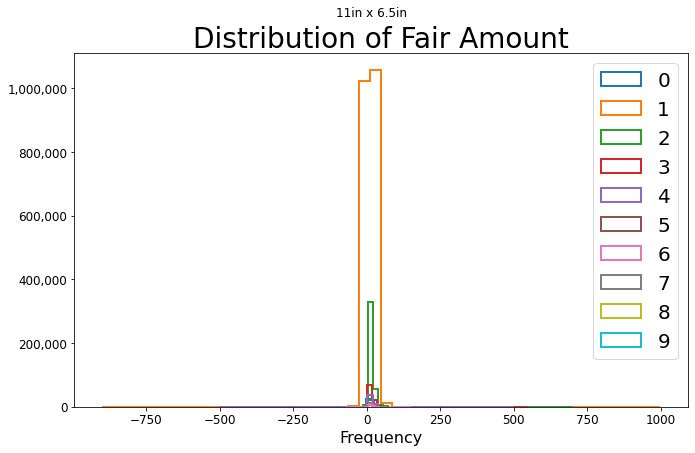

In [15]:
import matplotlib
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(11,6.5))
pass_count_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# mcolors.TABLEAU_COLORS
for n, c in zip(pass_count_values, list(mcolors.TABLEAU_COLORS)[:len(pass_count_values)]):
    plt.hist(df[(df.passenger_count==n)&(df.trip_distance<10)].fare_amount, bins=50, label=f'{n}', histtype='step', color=c, linewidth=2,)
plt.legend(fontsize="20")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.axes[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Fare [$]", fontsize=16)
plt.xlabel("Frequency", fontsize=16)
plt.title("Distribution of Fair Amount", fontsize=28)
plt.suptitle("11in x 6.5in", fontsize=12)
fig.show()
fig.savefig('plot_2_110x65.png')
# plt.close()

## Include Data Quality Table

Create a table

In [16]:
quality_numeric = df.describe(datetime_is_numeric=True).T
display(quality_numeric)

,count,mean,min,25%,50%,75%,max,std
VendorID,"3,066,766.00",1.73,1.00,1.00,2.00,2.00,2.00,0.44
tpep_pickup_datetime,3066766,2023-01-17 00:22:26.288164096,2008-12-31 23:01:42,2023-01-09 16:21:57.249999872,2023-01-17 08:42:29.500000,2023-01-24 16:26:27,2023-02-01 00:56:53,NaN
tpep_dropoff_datetime,3066766,2023-01-17 00:38:06.427873792,2009-01-01 14:29:11,2023-01-09 16:37:06,2023-01-17 08:58:30.500000,2023-01-24 16:42:49,2023-02-02 09:28:47,NaN
passenger_count,"2,995,023.00",1.36,0.00,1.00,1.00,1.00,9.00,0.90
trip_distance,"3,066,766.00",3.85,0.00,1.06,1.80,3.33,"258,928.15",249.58
RatecodeID,"2,995,023.00",1.50,1.00,1.00,1.00,1.00,99.00,6.47
PULocationID,"3,066,766.00",166.40,1.00,132.00,162.00,234.00,265.00,64.24
DOLocationID,"3,066,766.00",164.39,1.00,114.00,162.00,234.00,265.00,69.94
payment_type,"3,066,766.00",1.19,0.00,1.00,1.00,1.00,4.00,0.53
fare_amount,"3,066,766.00",18.37,-900.00,8.60,12.80,20.50,"1,160.10",17.81


Export to Excel:

In [19]:
quality_numeric.to_excel('table_quality_numeric.xlsx', index_label='field')

Downlaod Excel file, and drag onto the PowerPoint slide.